In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# For use on local machine
%cd ..

C:\Users\efurst1\PycharmProjects\ERM_GDRO


# Results Visualization

Data loading and plotting functions to visualize the results given by run.py  
Put the path of the folder containing the results in load_dir and run the cells to see results

## Defining functions & parameters

In [104]:
import matplotlib.pyplot as plt
import pandas as pd

# .csv to load results from
load_path = 'test_results/mnist/accuracies.csv'

In [117]:
def plot_acc(drop_epochs=[], err_margin=0):
    loaded_accuracies = pd.read_csv(load_path)
    N = max(loaded_accuracies["trial"]) + 1
    epochs = max(loaded_accuracies["epoch"]) + 1
    subtypes = list(loaded_accuracies["subtype"].unique())
    algorithms = loaded_accuracies.columns

    results = loaded_accuracies.drop(columns=["trial", "epoch", "subtype"]).to_dict('list')
    results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))
    
    trial_means = results_df.stack().unstack(level=0).mean(axis=1).unstack(level=2)
    trial_errs = results_df.stack().unstack(level=0).std(axis=1).unstack(level=2) / (N ** 0.5)

    trial_means.drop(drop_epochs, level=0, axis=0, inplace=True)
    hide = []
    
    subtypes = ["Overall", "8"]

    f, a = plt.subplots(len(subtypes), 1)

    # plot subtypes sensitivity

    for i in range(len(subtypes)):
        plot_data = trial_means.drop(columns=hide).xs(subtypes[i], level=1)
        plot_data.plot(ylim=[0.6,1],xlabel="Epoch",ylabel="Accuracy",kind='line',title=subtypes[i],ax=a[i],figsize=(24, 6 * len(subtypes)),grid=True)
        plot_errs = trial_errs.drop(columns=hide).xs(key=subtypes[i], level=1)
        for col in plot_data.columns:
            a[i].fill_between(list(plot_data.index), plot_data[col] + err_margin * plot_errs[col], plot_data[col] - err_margin * plot_errs[col], alpha=0.25)
        

In [118]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind

def ttest(p_threshold=0.05):
    print(f't-tests with significance threshold p<{p_threshold}\n')
    ttest_dataframes = {}

    loaded_accuracies = pd.read_csv(load_path)
    N = max(loaded_accuracies["trial"]) + 1
    epochs = max(loaded_accuracies["epoch"]) + 1
    subtypes = list(loaded_accuracies["subtype"].unique())
    algorithms = loaded_accuracies.columns

    results = loaded_accuracies.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')
    results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

    for s in range(len(subtypes)):
        epoch = epochs - 1

        subtype_data = results_df.xs(subtypes[s], level=2).xs(epoch, level=1)
        erm_data = subtype_data["ERMLoss"].values

        print(subtypes[s])
        for algorithm in results_df.columns:
            if algorithm != "ERMLoss":
                algorithm_data = subtype_data[algorithm].values
                stat, p = ttest_ind(algorithm_data, erm_data)

                print(f'ERMLoss: {erm_data.mean():.3f}, 1.96*stdErr: {(1.96 * erm_data.std(ddof=1) / (len(erm_data) ** 0.5)):.2e}')
                print(f'{algorithm}: {algorithm_data.mean():.3f}, 1.96*stdErr: {(1.96 * algorithm_data.std(ddof=1) / (len(algorithm_data) ** 0.5)):.2e}')
                if p < p_threshold:
                    print(f'{algorithm if stat > 0 else "ERMLoss"} greater with p = {p:.2e}')
                else:
                    print(f'No significant difference with p = {p:.2e}')
                print()

## Show results

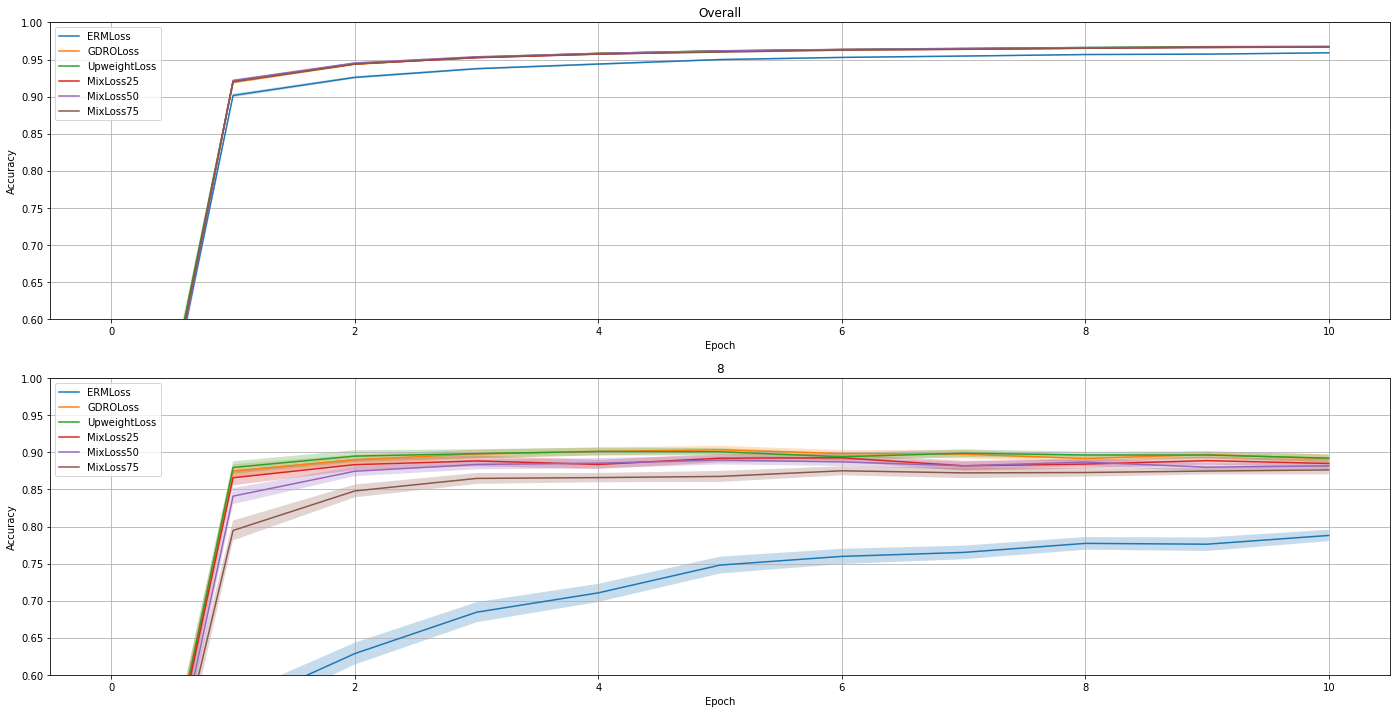

In [119]:
plot_acc(err_margin=1.96)

In [30]:
ttest(p_threshold=0.05)

t-tests with significance threshold p<0.05

Overall
ERMLoss: 0.960, 1.96*stdErr: 1.79e-03
GDROLoss: 0.968, 1.96*stdErr: 9.35e-04
GDROLoss greater with p = 3.11e-10

0
ERMLoss: 0.987, 1.96*stdErr: 1.27e-03
GDROLoss: 0.986, 1.96*stdErr: 1.81e-03
No significant difference with p = 1.80e-01

1
ERMLoss: 0.996, 1.96*stdErr: 5.46e-04
GDROLoss: 0.993, 1.96*stdErr: 1.06e-03
ERMLoss greater with p = 5.14e-04

2
ERMLoss: 0.985, 1.96*stdErr: 1.46e-03
GDROLoss: 0.981, 1.96*stdErr: 1.57e-03
ERMLoss greater with p = 4.09e-04

3
ERMLoss: 0.968, 1.96*stdErr: 3.11e-03
GDROLoss: 0.967, 1.96*stdErr: 2.67e-03
No significant difference with p = 5.40e-01

4
ERMLoss: 0.972, 1.96*stdErr: 3.15e-03
GDROLoss: 0.972, 1.96*stdErr: 3.42e-03
No significant difference with p = 9.21e-01

5
ERMLoss: 0.977, 1.96*stdErr: 2.39e-03
GDROLoss: 0.975, 1.96*stdErr: 2.79e-03
No significant difference with p = 4.06e-01

6
ERMLoss: 0.981, 1.96*stdErr: 1.69e-03
GDROLoss: 0.980, 1.96*stdErr: 1.96e-03
No significant difference with p

In [44]:
from wilds import get_dataset

In [48]:
ds = get_dataset("waterbirds", download=True)

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


0Byte [00:00, ?Byte/s]

Extracting data\waterbirds_v1.0\archive.tar.gz to data\waterbirds_v1.0

It took 1.73 minutes to download and uncompress the dataset.



In [126]:
ds._metadata_array = 2 * ds._metadata_array[:, 1] + ds._metadata_array[:, 0]

In [142]:
from torchvision import transforms
dstrain = ds.get_subset(
    "train",
    transform=transforms.Compose(
        [transforms.Resize((448, 448)), transforms.ToTensor(), transforms.Lambda(lambda x: x.to('cuda'))]
    ),)

In [143]:
from dataloaders import InfiniteDataLoader

In [144]:
next(InfiniteDataLoader(dstrain, batch_size=3))

[tensor([[[[0.1647, 0.1686, 0.1216,  ..., 0.4353, 0.1843, 0.2353],
           [0.1608, 0.1882, 0.1725,  ..., 0.4941, 0.4157, 0.4706],
           [0.1804, 0.1922, 0.1922,  ..., 0.6078, 0.6431, 0.6510],
           ...,
           [0.0902, 0.0863, 0.0863,  ..., 0.0549, 0.0549, 0.0549],
           [0.0863, 0.0784, 0.0784,  ..., 0.0510, 0.0510, 0.0510],
           [0.0824, 0.0706, 0.0706,  ..., 0.0471, 0.0471, 0.0471]],
 
          [[0.1569, 0.1608, 0.1098,  ..., 0.5020, 0.2549, 0.3059],
           [0.1529, 0.1804, 0.1647,  ..., 0.5647, 0.4863, 0.5412],
           [0.1725, 0.1804, 0.1804,  ..., 0.6784, 0.7137, 0.7216],
           ...,
           [0.1216, 0.1137, 0.1059,  ..., 0.0667, 0.0667, 0.0667],
           [0.1176, 0.1059, 0.1020,  ..., 0.0627, 0.0627, 0.0627],
           [0.1137, 0.1020, 0.1020,  ..., 0.0588, 0.0588, 0.0588]],
 
          [[0.0588, 0.0667, 0.0314,  ..., 0.3490, 0.0980, 0.1490],
           [0.0549, 0.0824, 0.0784,  ..., 0.4078, 0.3294, 0.3843],
           [0.0706, 0.08

In [135]:
dstrain[0][0].device

device(type='cpu')

In [136]:
torch.cuda.is_available()

True

In [146]:
from utils.process_data_utils import get_waterbirds_dataloaders

In [151]:
next(get_waterbirds_dataloaders(128, device='cuda')[0])

[tensor([[[[0.0824, 0.0706, 0.1098,  ..., 0.1294, 0.0980, 0.1176],
           [0.0588, 0.0824, 0.0824,  ..., 0.1333, 0.1176, 0.1255],
           [0.0353, 0.0510, 0.0314,  ..., 0.1255, 0.1137, 0.1020],
           ...,
           [0.2275, 0.2196, 0.0863,  ..., 0.0118, 0.0118, 0.0118],
           [0.2118, 0.2118, 0.0627,  ..., 0.0078, 0.0078, 0.0078],
           [0.2235, 0.1961, 0.0824,  ..., 0.0039, 0.0078, 0.0118]],
 
          [[0.1176, 0.1020, 0.1451,  ..., 0.1647, 0.1333, 0.1529],
           [0.0863, 0.1098, 0.1137,  ..., 0.1686, 0.1529, 0.1647],
           [0.0549, 0.0745, 0.0549,  ..., 0.1647, 0.1490, 0.1373],
           ...,
           [0.2549, 0.2353, 0.0863,  ..., 0.0157, 0.0118, 0.0196],
           [0.2392, 0.2275, 0.0667,  ..., 0.0078, 0.0078, 0.0157],
           [0.2549, 0.2157, 0.0863,  ..., 0.0039, 0.0118, 0.0196]],
 
          [[0.0235, 0.0078, 0.0314,  ..., 0.0745, 0.0235, 0.0275],
           [0.0196, 0.0353, 0.0275,  ..., 0.0588, 0.0314, 0.0314],
           [0.0235, 0.03

In [152]:
!python run.py waterbirds --verbose

C:\Users\efurst1\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
Traceback (most recent call last):
  File "C:\Users\efurst1\PycharmProjects\ERM_GDRO\run.py", line 3, in <module>
    import models
  File "C:\Users\efurst1\PycharmProjects\ERM_GDRO\models.py", line 3, in <module>
    import torchvision
  File "C:\Users\efurst1\Anaconda3\lib\site-packages\torchvision\__init__.py", line 7, in <module>
    from torchvision import models
  File "C:\Users\efurst1\Anaconda3\lib\site-packages\torchvision\models\__init__.py", line 18, in <module>
    from . import quantization
  File "C:\Users\efurst1\Anaconda3\lib\site-packages\torchvision\models\quantization\__init__.py", line 1, in <module>
    from .mobilenet import *
  File "C:\Users\efurst1\Anaconda3\lib\site-packages\torchvision\models\quantization\mobilenet.py", line 1